**Model 2 (Bert + Fine Tuning)**
* Pre-trained Bert Model
* Binary Cross-Entropy (BCE) and Focal Loss as loss functions


**Results for BCE Loss**

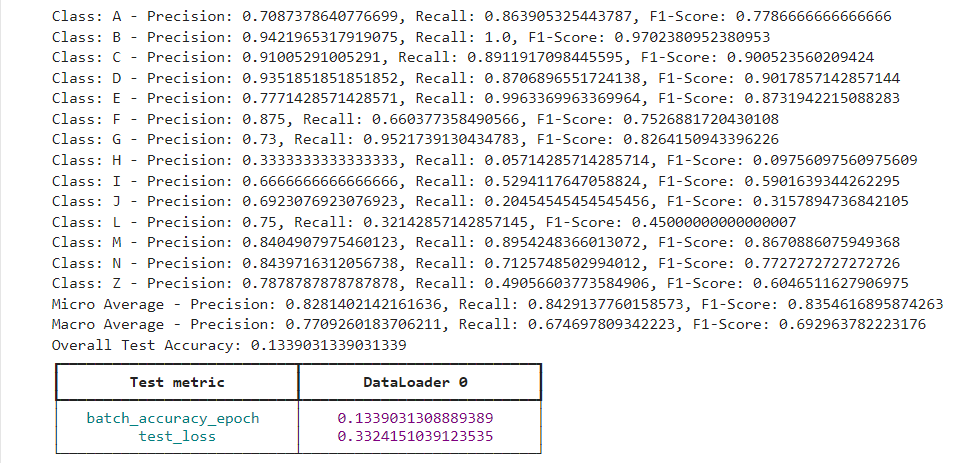

**Results for Focal Loss**

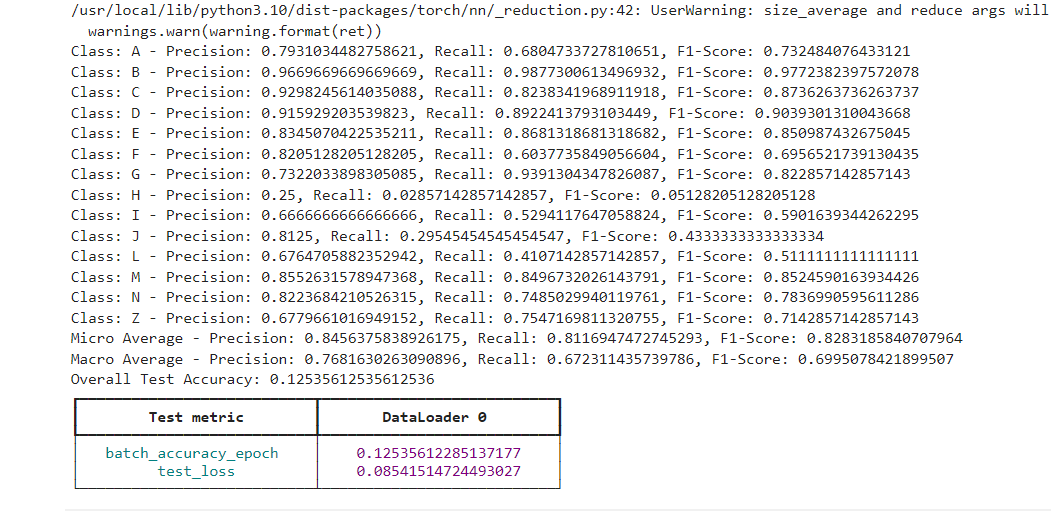

**Observations**
* Although we are getting almost same value of metrics still the value of loss for Focal loss is less than that of BCE Loss

In [ ]:
!pip install pytorch-lightning

In [ ]:
pip install -U typing_extensions

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# dataset_name = r"C:\Users\Dell\Desktop\Sem_8\Ell881_Modern_NLP\Assignment 3\Multi-Label Text Classification Dataset.csv"
dataset_name = r"/content/Multi-Label Text Classification Dataset.csv"

df = pd.read_csv(dataset_name, engine='python', on_bad_lines='skip')
# Fill NaN values with empty strings in both 'Title' and 'abstractText' columns
df['Title'] = df['Title'].fillna('')
df['abstractText'] = df['abstractText'].fillna('')

# Create a smaller DataFrame with the first 1000 rows
# df = df.sample(n=1000, random_state=1)

# Define the label mappings
label_mappings = {
    "A": "Anatomy",
    "B": "Organisms",
    "C": "Diseases",
    "D": "Chemicals and Drugs",
    "E": "Analytical, Diagnostic and Therapeutic Techniques, and Equipment",
    "F": "Psychiatry and Psychology",
    "G": "Phenomena and Processes",
    "H": "Disciplines and Occupations",
    "I": "Anthropology, Education, Sociology, and Social Phenomena",
    "J": "Technology, Industry, and Agriculture",
    "L": "Information Science",
    "M": "Named Groups",
    "N": "Health Care",
    "Z": "Geographicals"
}

labels = []
for index, row in df.iterrows():
    row_labels = [label for label, present in row[label_mappings.keys()].items() if present == 1]
    labels.append(row_labels)

# Encode labels as one-hot vectors
mlb = MultiLabelBinarizer()
df['one_hot_labels'] = list(mlb.fit_transform(labels))

In [ ]:
# Split the dataset into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(df[['Title', 'abstractText']], df['one_hot_labels'], test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Convert both title and abstractText to strings, handling any missing values
        title = str(self.texts.iloc[idx]['Title'])
        abstract = str(self.texts.iloc[idx]['abstractText'])

        # Concatenate title and abstract, separating them with a space
        text = title + ' ' + abstract

        # text = self.texts.iloc[idx]['Title'] + ' ' + self.texts.iloc[idx]['abstractText']
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

In [ ]:
# DataModule class
class DataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=16):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
# Model class
class MultiLabelClassifier(pl.LightningModule):
    def __init__(self, n_classes, loss_type='BCEWithLogitsLoss', steps_per_epoch=None, n_epochs=3, lr=2e-5):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

        # Choose the loss function based on the input parameter
        if loss_type == 'BCEWithLogitsLoss':
            self.criterion = nn.BCEWithLogitsLoss()
        elif loss_type == 'FocalLoss':
            self.criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)
        else:
            raise ValueError("Invalid loss type provided: choose 'BCEWithLogitsLoss' or 'FocalLoss'")

        # Other attributes
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(output.pooler_output)

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        val_loss = self.criterion(outputs, labels)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)

        # Apply sigmoid to get probabilities and round to get predictions
        preds = torch.sigmoid(outputs).round().int()

        # Save the labels and predictions as instance attributes
        if batch_idx == 0:
            self.predictions = preds
            self.labels = labels.int()
        else:
            self.predictions = torch.cat((self.predictions, preds), dim=0)
            self.labels = torch.cat((self.labels, labels.int()), dim=0)

        # Calculate and log batch accuracy
        batch_accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        self.log('batch_accuracy', batch_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'test_loss': loss, 'batch_accuracy': batch_accuracy}

    def on_test_epoch_end(self):
      # Access the saved predictions and labels
      all_preds = self.predictions.cpu()  # Move to CPU
      all_labels = self.labels.cpu()  # Move to CPU

      # Convert to NumPy arrays
      all_preds_np = all_preds.numpy()
      all_labels_np = all_labels.numpy()

      # Calculate metrics for each class
      for i, class_name in enumerate(mlb.classes_):
          precision, recall, f1, _ = precision_recall_fscore_support(all_labels_np[:, i], all_preds_np[:, i], average='binary')
          print(f"Class: {class_name}")
          print(f" Precision: {precision}")
          print(f" Recall: {recall}")
          print(f" F1-Score: {f1}")

      # Calculate overall accuracy
      overall_accuracy = accuracy_score(all_labels_np, all_preds_np)
      print(f"Overall Test Accuracy: {overall_accuracy}")

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.lr)

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)

        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

In [ ]:
pip install --upgrade pytorch-lightning

In [ ]:
# Prepare datasets
train_dataset = TextDataset(x_train, np.array(y_train.tolist()), tokenizer)
val_dataset = TextDataset(x_val, np.array(y_val.tolist()), tokenizer)
test_dataset = TextDataset(x_test, np.array(y_test.tolist()), tokenizer)

# Prepare data module
data_module = DataModule(train_dataset, val_dataset, test_dataset, batch_size=16)

# Instantiate the model with BCEWithLogitsLoss
model1 = MultiLabelClassifier(n_classes=len(mlb.classes_), loss_type='BCEWithLogitsLoss', steps_per_epoch=len(train_dataset)//16, n_epochs=3, lr=2e-5)

trainer = pl.Trainer(max_epochs=3, accelerator='gpu', devices=1 if torch.cuda.is_available() else None)

# Train the model
trainer.fit(model1, data_module)

In [ ]:
# Evaluate the model
trainer.test(model1, datamodule=data_module)

# Save the model
torch.save(model1.state_dict(), 'multi_label_text_classification_model1.pth')

In [ ]:
# Instantiate the model with FocalLoss
model2 = MultiLabelClassifier(n_classes=len(mlb.classes_), loss_type='FocalLoss', steps_per_epoch=len(train_dataset)//16, n_epochs=3, lr=2e-5)
trainer = pl.Trainer(max_epochs=3, accelerator='gpu', devices=1 if torch.cuda.is_available() else None)

# Train the model
trainer.fit(model2, data_module)

In [ ]:
# Evaluate the model
trainer.test(model2, datamodule=data_module)

# Save the model
torch.save(model2.state_dict(), 'multi_label_text_classification_model2.pth')